# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('catdog/train/*.jpg')
test_files = glob('catdog/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return array  

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if '\dog' in path else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

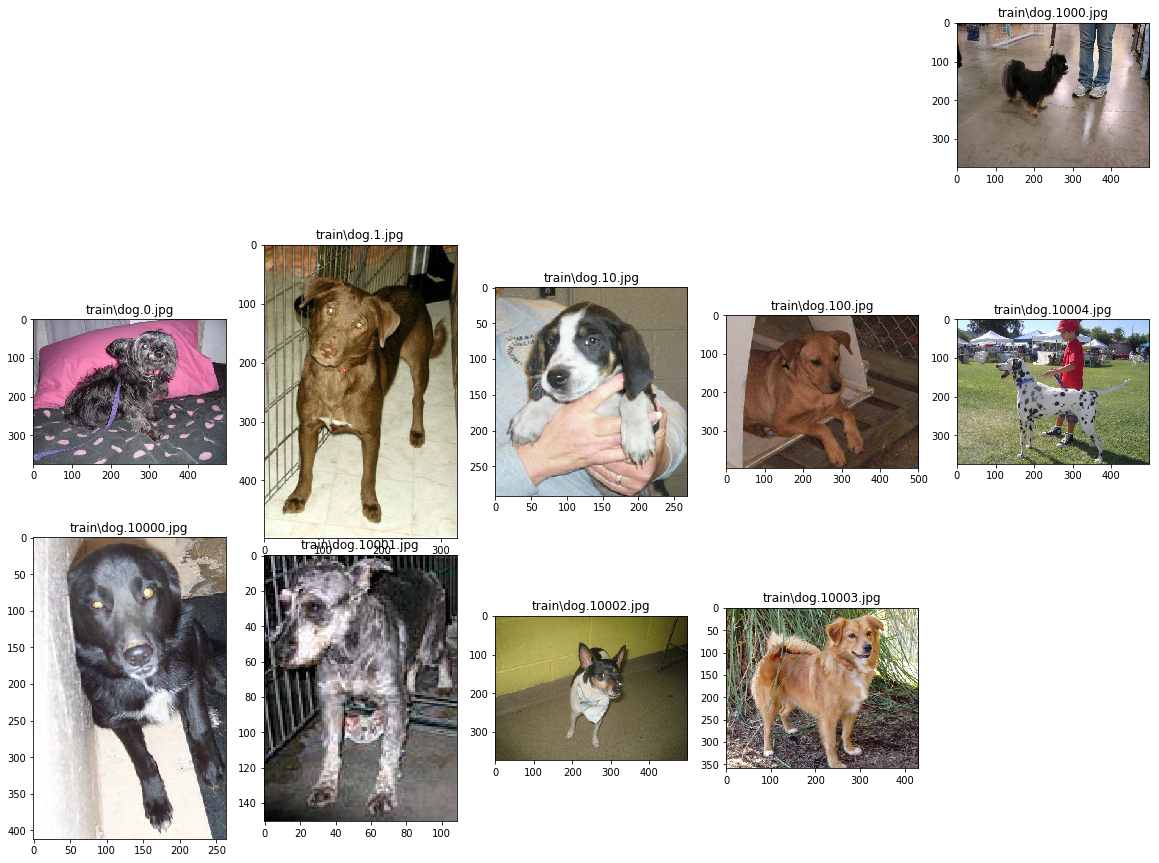

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[12500:12510], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [5]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers[:240]:
    layer.trainable = False

In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

__________________________________________________________________________________________________
mixed8 (Concatenate)            (None, 5, 5, 1280)   0           activation_71[0][0]              
                                                                 activation_75[0][0]              
                                                                 max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 5, 5, 448)    573440      mixed8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_80 (Batc (None, 5, 5, 448)    1344        conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 5, 5, 448)    0           batch_normalization_v1_80[0][0]  
__________

In [8]:
base_model.layers[240]

## Добавляем полносвязный слой

In [9]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

## Компилируем модель и запускаем обучение

In [11]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [12]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10/10 [==============================] - 150s 15s/step - loss: 0.6437 - acc: 0.8406 - val_loss: 7.6273 - val_acc: 0.5300
Epoch 2/5
10/10 [==============================] - 143s 14s/step - loss: 0.4708 - acc: 0.9344 - val_loss: 7.6284 - val_acc: 0.5300
Epoch 3/5
10/10 [==============================] - 113s 11s/step - loss: 0.3932 - acc: 0.8906 - val_loss: 7.6285 - val_acc: 0.5300
Epoch 4/5
10/10 [==============================] - 98s 10s/step - loss: 0.1652 - acc: 0.9469 - val_loss: 5.7774 - val_acc: 0.5300
Epoch 5/5
10/10 [==============================] - 98s 10s/step - loss: 0.1500 - acc: 0.9344 - val_loss: 6.5827 - val_acc: 0.5400


In [13]:
model.save('cats-dogs-incv3.hdf5')

## Предсказания на проверочной выборке

In [14]:
pred = model.predict_generator(model.predict_generator(test_files), len(test_files), max_queue_size=500)

TypeError: clip() got an unexpected keyword argument 'min'

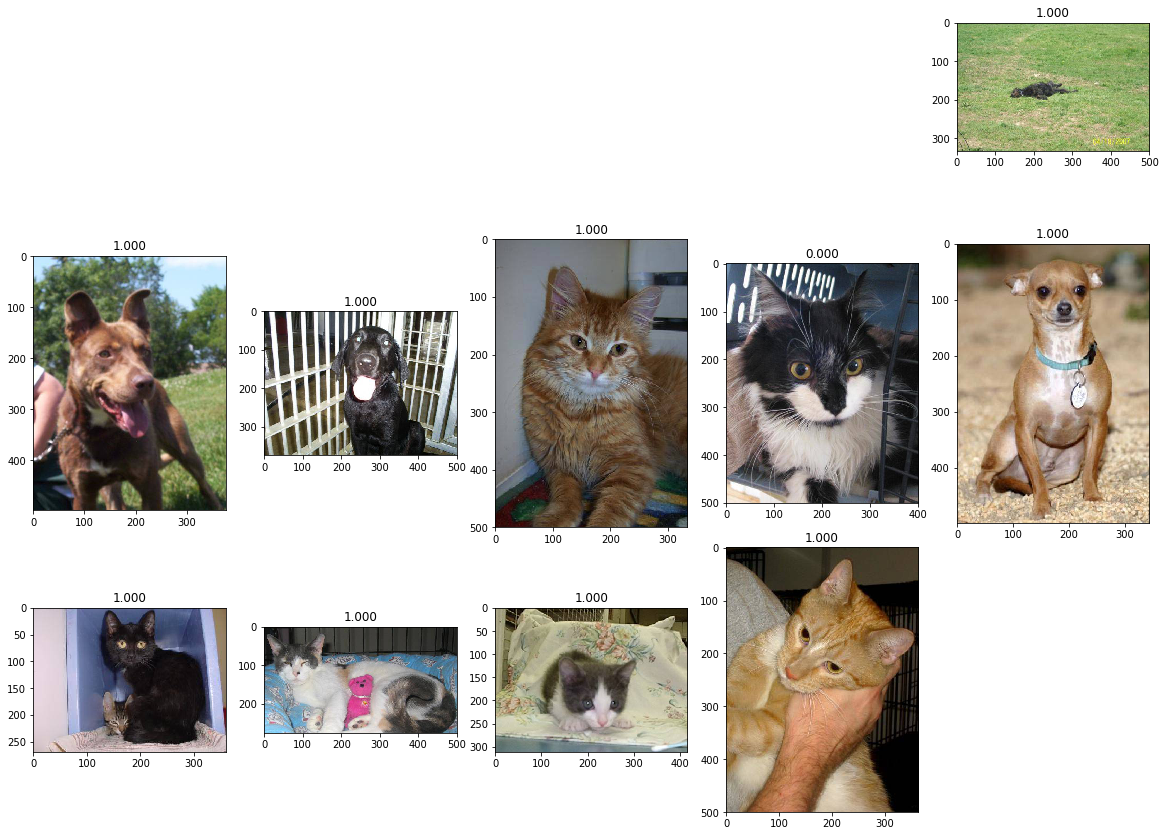

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [16]:
with open('submitcat.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [17]:
# LogLoss = 1.04979